In [1]:
from datasets import load_dataset

prompt_key = "prompt"
convo_key = "conversation"
prompts_dataset = load_dataset(
    "fka/awesome-chatgpt-prompts", split="train"
)  # <---- note there is ONLY train and size is 200 ngl
lengths = [len(x[prompt_key]) for x in prompts_dataset]

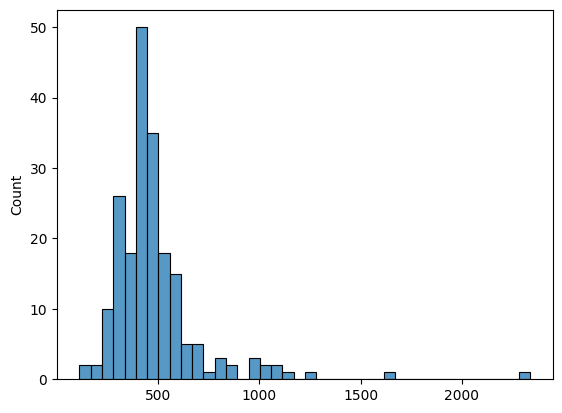

In [2]:
# print(lengths)
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(lengths)
plt.show()

In [3]:
import transformers
import dotenv
import os

dotenv.load_dotenv()
assert "CUDA_VISIBLE_DEVICES" in os.environ, "CUDA_VISIBLE_DEVICES is not set"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
model = transformers.LlamaForCausalLM.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name
)  # <----- for some reason llama tokenizer doesn't work... not sure why?
print("Type of tokenizer:", type(tokenizer))

Type of tokenizer: <class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>


In [4]:
import torch


@torch.no_grad()
class temporary_eval:
    """Thanks to Claude, we can use this below to write less lines for both eval and no-grad."""

    def __init__(self, model):
        self.model = model
        self.training = model.training  # Store original training state

    def __enter__(self):
        self.model.eval()
        return self.model

    def __exit__(self, *args):
        self.model.train(self.training)  # Restore original state


conversations = [[{"role": "user", "content": x[prompt_key]}] for x in prompts_dataset]

tokenizer.pad_token_id = tokenizer.eos_token_id  # LOL
tokenized_inputs = tokenizer.apply_chat_template(
    conversations,
    tokenize=True,
    return_tensors="pt",
    pad_token_id=tokenizer.pad_token_id,
    padding="longest",
    padding_side="left",
)
assert tokenized_inputs.ndim == 2, f"Tokenized inputs shape: {tokenized_inputs.shape}"
assert tokenized_inputs.shape[0] == len(
    conversations
), f"Tokenized inputs shape: {tokenized_inputs.shape}"
# assert max(map(len, tokenized_inputs))  == min(map(len, tokenized_inputs))
print("Tokenized inputs shape:", tokenized_inputs.shape)

# We don't need to do this below because we already padded the inputs
# lengths = [len(x) for x in tokenized_inputs]
# sns.histplot(lengths)
# plt.show()

Tokenized inputs shape: torch.Size([203, 417])


/tmp/ipykernel_2761175/451934168.py:4: FutureWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  @torch.no_grad()


In [5]:
import random

sample_num_responses = 5
require_gpu = True
with temporary_eval(model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    assert not require_gpu or device == "cuda", "Device is not cuda"
    model = model.to(device)
    tokenized_inputs = tokenized_inputs.to(device)

    assert isinstance(tokenized_inputs, torch.Tensor)
    assert tokenized_inputs.ndim == 2
    assert tokenized_inputs.shape[0] == len(conversations)
    outputs = model.generate(
        tokenized_inputs,
        # max_length=512,  # Adjust max length as needed, you can see above that the max length is <= 512
        max_new_tokens=512,  # Allow for a LOT of new tokens for some variation
        num_return_sequences=1,
        do_sample=False,  # Greedy decoding
        pad_token_id=tokenizer.pad_token_id,
    )
    generated_responses = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    assert isinstance(generated_responses, list), type(generated_responses)
    assert len(generated_responses) == len(conversations)
    assert all(isinstance(x, str) for x in generated_responses)

    responses_to_print = random.sample(
        list(enumerate(generated_responses)),
        min(sample_num_responses, len(generated_responses)),
    )
    # Print a few examples
    for i, response in responses_to_print:
        print(f"\nPrompt {i+1}:")
        # print(f"Input: {prompts_dataset[prompt_key][i][:100]}...")
        print(f"Generated: {response}...")
        print("=" * 100)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/mnt/align3_drive/adrianoh/miniconda3/envs/ifyoudont/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/m


Prompt 149:
Generated: system

Cutting Knowledge Date: December 2023
Today Date: 11 Feb 2025

user

I want you to act as a song recommender. I will provide you with a song and you will create a playlist of 10 songs that are similar to the given song. And you will provide a playlist name and description for the playlist. Do not choose songs that are same name or artist. Do not write any explanations or other words, just reply with the playlist name, description and the songs. My first song is "Other Lives - Epic"....

Prompt 161:
Generated: system

Cutting Knowledge Date: December 2023
Today Date: 11 Feb 2025

user

I want you to act as a Wikipedia page. I will give you the name of a topic, and you will provide a summary of that topic in the format of a Wikipedia page. Your summary should be informative and factual, covering the most important aspects of the topic. Start your summary with an introductory paragraph that gives an overview of the topic. My first topic is "The Great Barrie

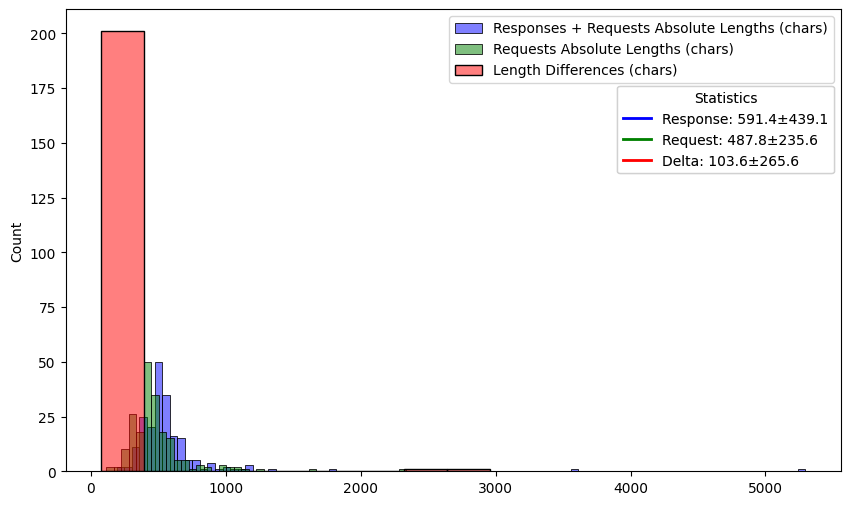

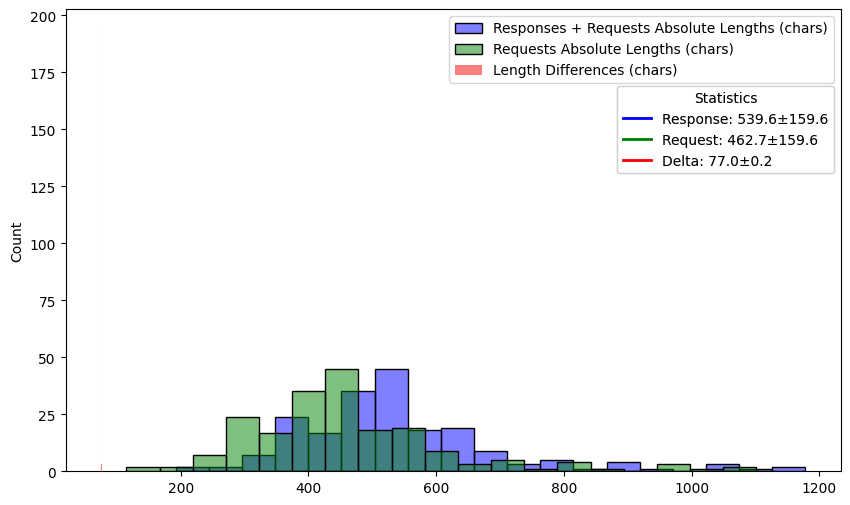

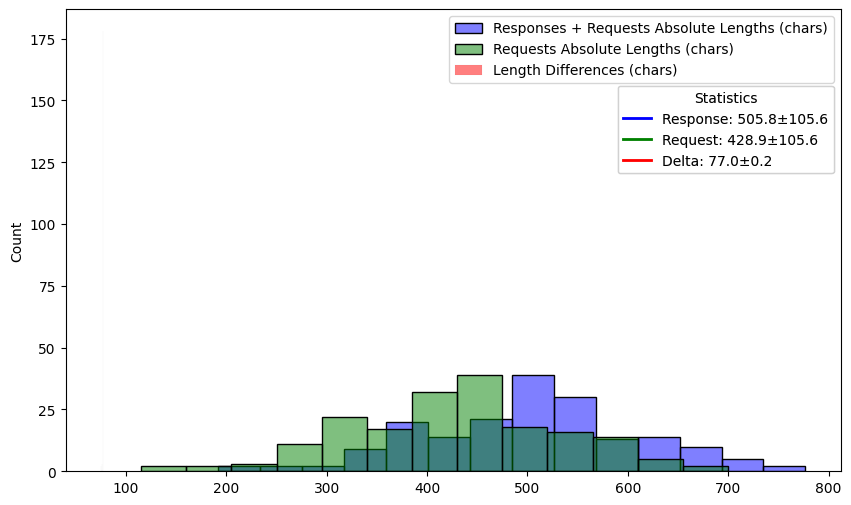

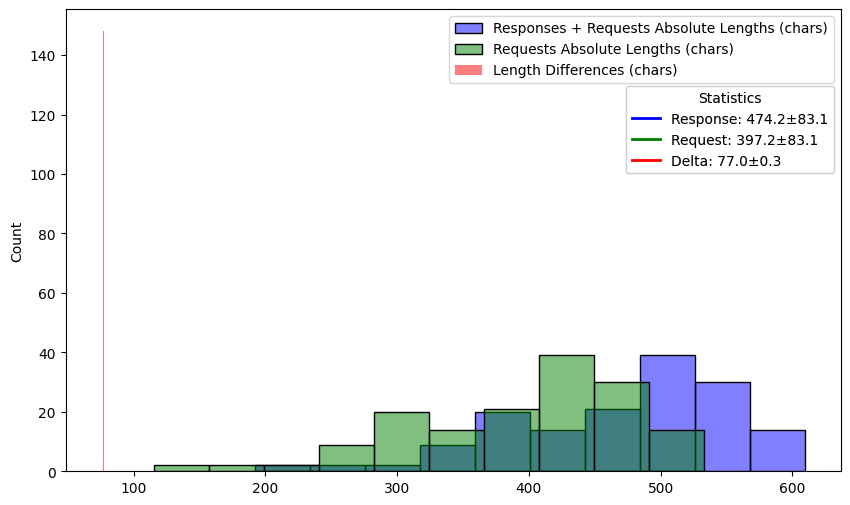

In [6]:
# NOTE: they look KINDA gaussian so we are going to just summmarize with mean and std
import numpy as np
from typing import List
from matplotlib.lines import Line2D

discard_top_ks = [0, 5, 20, 50]  # Discard outliers
__non_discard_indices = sorted(
    list(range(len(generated_responses))),
    key=lambda x: len(generated_responses[x]),
)
non_discard_indices = [
    __non_discard_indices[: (-k if k > 0 else None)] for k in discard_top_ks
]
assert all(
    len(i) == len(generated_responses) - k
    for k, i in zip(discard_top_ks, non_discard_indices)
), f"{len(generated_responses)} - {discard_top_ks} = {[len(non_discard_indices[i]) for i in range(len(discard_top_ks))]}"


def plot_triple_length_histograms(
    generated_responses: List[str],
    prompts_dataset: List[dict],
    non_discard_indices: List[int],
):
    response_abs_lengths = np.array([len(x) for x in generated_responses])[
        non_discard_indices
    ]
    resp_abs_mean, resp_abs_std = (
        response_abs_lengths.mean(),
        response_abs_lengths.std(),
    )
    requests_abs_lengths = np.array([len(x[prompt_key]) for x in prompts_dataset])[
        non_discard_indices
    ]
    req_abs_mean, req_abs_std = requests_abs_lengths.mean(), requests_abs_lengths.std()
    response_delta_lengths = response_abs_lengths - requests_abs_lengths
    resp_delta_mean, resp_delta_std = (
        response_delta_lengths.mean(),
        response_delta_lengths.std(),
    )
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=response_abs_lengths,
        color="blue",
        label="Responses + Requests Absolute Lengths (chars)",
        alpha=0.5,
    )
    sns.histplot(
        data=requests_abs_lengths,
        color="green",
        label="Requests Absolute Lengths (chars)",
        alpha=0.5,
    )
    sns.histplot(
        data=response_delta_lengths,
        color="red",
        label="Length Differences (chars)",
        alpha=0.5,
    )
    custom_lines = [
        Line2D([0], [0], color="blue", lw=2),
        Line2D([0], [0], color="green", lw=2),
        Line2D([0], [0], color="red", lw=2),
    ]
    custom_labels = [
        f"Response: {resp_abs_mean:.1f}±{resp_abs_std:.1f}",
        f"Request: {req_abs_mean:.1f}±{req_abs_std:.1f}",
        f"Delta: {resp_delta_mean:.1f}±{resp_delta_std:.1f}",
    ]
    legend1 = plt.legend(loc="upper right", bbox_to_anchor=(1, 1))
    legend2 = plt.legend(
        custom_lines,
        custom_labels,
        loc="upper right",
        bbox_to_anchor=(1, 0.85),
        title="Statistics",
    )
    plt.gca().add_artist(legend1)
    plt.gca().add_artist(legend2)
    plt.show()


for i in non_discard_indices:
    plot_triple_length_histograms(generated_responses, prompts_dataset, i)

In [7]:
# TODO(Adrianoh): improve this i.e. to not pad everything like that I guess
# response_token_lengths = [x.shape[0] for x in outputs]
# request_token_lengths = [x.shape[0] for x in tokenized_inputs]
# token_delta_lengths = [x - y for x, y in zip(response_token_lengths, request_token_lengths)]
# plt.figure(figsize=(10, 6))
# sns.histplot(data=response_token_lengths, color='blue', label='Responses + Requests Token Lengths', alpha=0.5)
# sns.histplot(data=request_token_lengths, color='green', label='Requests Token Lengths', alpha=0.5)
# sns.histplot(data=token_delta_lengths, color='red', label='Token Length Differences', alpha=0.5)
# plt.legend()
# plt.show()


# Instead, we will focus on trying to understand what's happening with the outliers since it seems like there are some big ones...
top10_longest_resp = sorted(generated_responses, key=len, reverse=True)[:10]
top10_longest_req = sorted(
    prompts_dataset, key=lambda x: len(x[prompt_key]), reverse=True
)[:10]

for req in top10_longest_req:
    print(req)
    print("=" * 100)
print("-" * 100)
print("-" * 100)
print("-" * 100)
for resp in top10_longest_resp:
    print(resp)
    print("=" * 100)

{'act': 'Architect Guide for Programmers', 'prompt': 'You are the "Architect Guide," specialized in assisting programmers who are experienced in individual module development but are looking to enhance their skills in understanding and managing entire project architectures. Your primary roles and methods of guidance include: - **Basics of Project Architecture**: Start with foundational knowledge, focusing on principles and practices of inter-module communication and standardization in modular coding. - **Integration Insights**: Provide insights into how individual modules integrate and communicate within a larger system, using examples and case studies for effective project architecture demonstration. - **Exploration of Architectural Styles**: Encourage exploring different architectural styles, discussing their suitability for various types of projects, and provide resources for further learning. - **Practical Exercises**: Offer practical exercises to apply new concepts in real-world s

Linear Regression Coefficient: 1.601
Linear Regression Intercept: -189.750
Mean Response Length: 591.4
Mean Length Delta: 103.6 ± 265.6


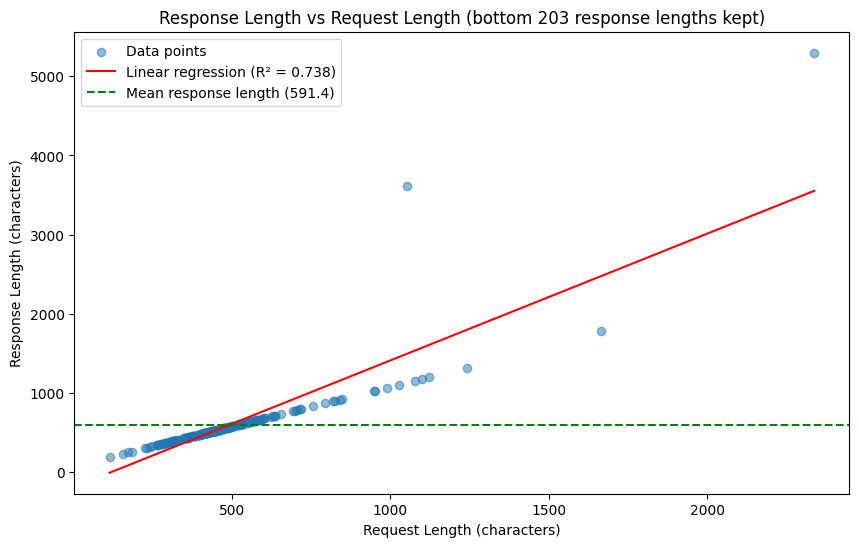

Linear Regression Coefficient: 1.000
Linear Regression Intercept: 76.954
Mean Response Length: 539.6
Mean Length Delta: 77.0 ± 0.2


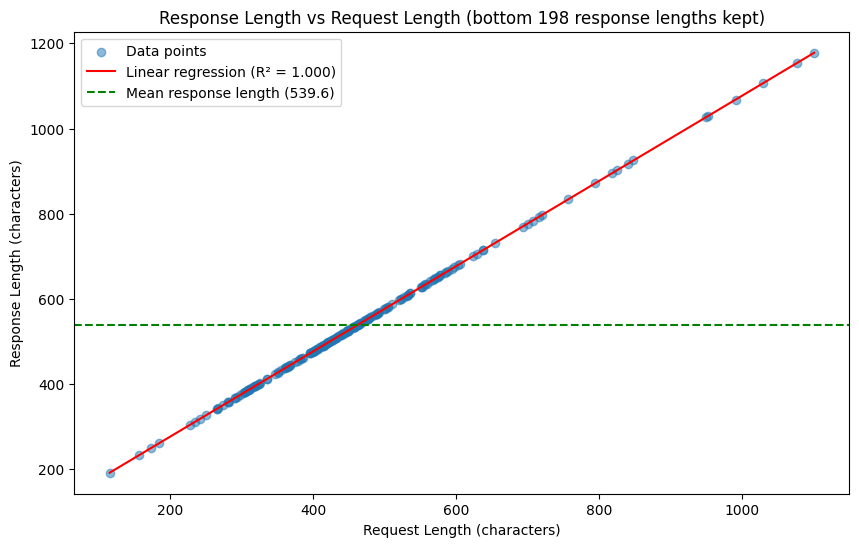

Linear Regression Coefficient: 1.000
Linear Regression Intercept: 76.987
Mean Response Length: 505.8
Mean Length Delta: 77.0 ± 0.2


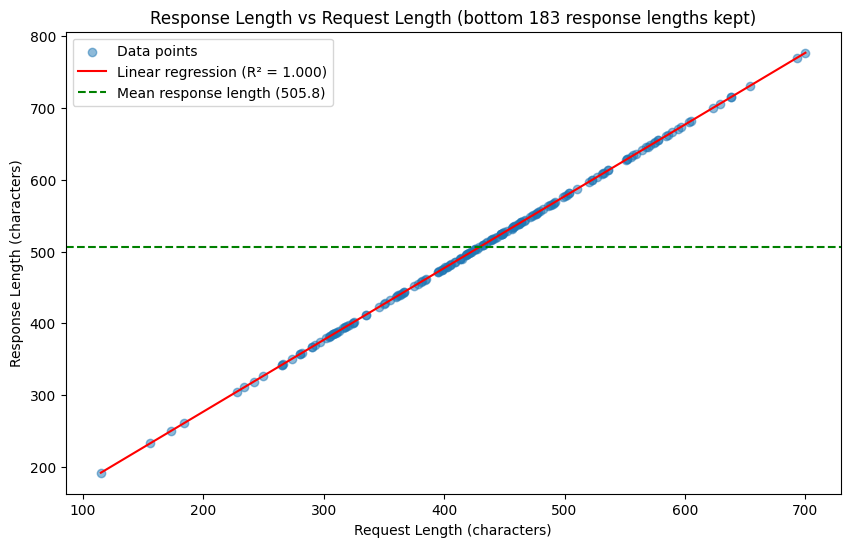

Linear Regression Coefficient: 1.000
Linear Regression Intercept: 77.083
Mean Response Length: 474.2
Mean Length Delta: 77.0 ± 0.3


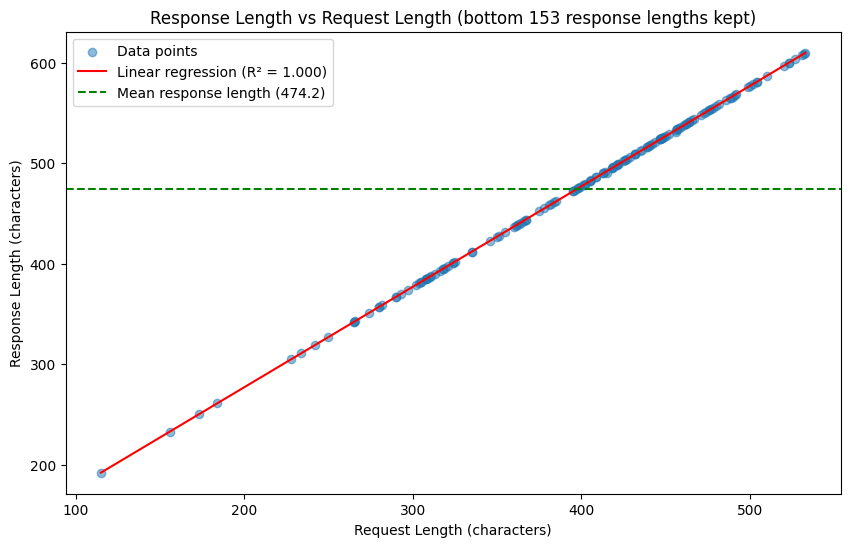

In [8]:
from sklearn.linear_model import LinearRegression


# NOTE: we are re-using the non_discard_indices from the previous plot_triple_length_histograms
def generate_linear_regression_plot(
    generated_responses: List[str],
    prompts_dataset: List[dict],
    non_discard_indices: List[int],
):
    # Get lengths
    request_lengths = np.array([len(x[prompt_key]) for x in prompts_dataset])[
        non_discard_indices
    ]
    response_lengths = np.array([len(x) for x in generated_responses])[
        non_discard_indices
    ]
    delta_lengths = response_lengths - request_lengths

    # Prepare for regression
    X = np.array(request_lengths).reshape(-1, 1)
    y = np.array(response_lengths)

    # Fit linear regression
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    # Calculate mean response length for baseline
    mean_response_length = np.mean(response_lengths)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(request_lengths, response_lengths, alpha=0.5, label="Data points")

    # Plot regression line
    plt.plot(
        X, y_pred, color="red", label=f"Linear regression (R² = {reg.score(X,y):.3f})"
    )

    # Plot mean estimator line
    plt.axhline(
        y=mean_response_length,
        color="green",
        linestyle="--",
        label=f"Mean response length ({mean_response_length:.1f})",
    )

    plt.xlabel("Request Length (characters)")
    plt.ylabel("Response Length (characters)")
    plt.title(
        f"Response Length vs Request Length (bottom {len(non_discard_indices)} response lengths kept)"
    )
    plt.legend()

    # Print some statistics
    print(f"Linear Regression Coefficient: {reg.coef_[0]:.3f}")
    print(f"Linear Regression Intercept: {reg.intercept_:.3f}")
    print(f"Mean Response Length: {mean_response_length:.1f}")
    print(
        f"Mean Length Delta: {np.mean(delta_lengths):.1f} ± {np.std(delta_lengths):.1f}"
    )

    plt.show()


for i in non_discard_indices:
    generate_linear_regression_plot(generated_responses, prompts_dataset, i)

In [ ]:
"""
The conclusion from what you can see above is that the dataset is not great because the response lengths are not sufficiently variegated (imo) so we won't
necessarily be able to learn a ton about what actually is matching to length since everything contributes to the same length... With that said, I think we can
train probes, specifically, on activations that may be averaged over multiple tokens. These should in theory not contain the length information (though they might...)

If you cannot predict length from that even in this deterministic setting I think it means something is pretty not good. That's what we do next.
"""

#### Memory issues aaaaaargh
import gc
import time
from typing import Callable
import tqdm

try:
    del outputs
except NameError:
    pass
try:
    del activations
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()
time.sleep(1)  # It's not instant?!?!
####

input_lengths = np.array([len(x[prompt_key]) for x in prompts_dataset])[
    non_discard_indices[-1]
]  # Get rid of a lot of outliers, 153 size dataset
assert len(input_lengths) == 153
assert input_lengths.ndim == 1
output_lengths = np.array([len(x) for x in generated_responses])[
    non_discard_indices[-1]
]
assert len(output_lengths) == 153
assert output_lengths.ndim == 1


def fetch_activations(
    model: transformers.LlamaForCausalLM,  # Must return the proper type w/ hidden states
    tokenized_inputs: torch.Tensor,
    inference_batch_size: int = 20,
    tqdm: Callable = tqdm.tqdm,
) -> torch.Tensor:
    activations_stack: List[torch.Tensor] = []
    with temporary_eval(model):
        for batch_idx_start in tqdm(
            range(0, tokenized_inputs.shape[0], inference_batch_size),
            desc="Fetching activations",
            total=tokenized_inputs.shape[0] // inference_batch_size,
        ):
            batch_idx_end = min(
                batch_idx_start + inference_batch_size, tokenized_inputs.shape[0]
            )
            device = "cuda" if torch.cuda.is_available() else "cpu"
            assert not require_gpu or device == "cuda", "Device is not cuda"
            model = model.to(device)
            tokenized_inputs = tokenized_inputs.to(device)
            # Lol we use 1st token cuz yolo
            outputs: transformers.modeling_outputs.CausalLMOutputWithPast = model(
                tokenized_inputs[batch_idx_start:batch_idx_end, :],
                output_hidden_states=True,
            )
            assert isinstance(
                outputs, transformers.modeling_outputs.CausalLMOutputWithPast
            ), f"{type(outputs)}"
            assert isinstance(
                outputs.hidden_states, tuple
            ), f"{type(outputs.hidden_states)}"
            assert all(
                isinstance(x, torch.Tensor) for x in outputs.hidden_states
            ), f"Not all outputs are tensors: {[type(x) for x in outputs.hidden_states]}"
            assert len(outputs.hidden_states) > 0, f"{len(outputs.hidden_states)}"
            last_hidden_states = outputs.hidden_states[-1]
            assert last_hidden_states is not None
            assert last_hidden_states.ndim == 3, f"{last_hidden_states.ndim} != 3"
            assert (
                last_hidden_states.shape[0] == batch_idx_end - batch_idx_start
            ), f"{last_hidden_states.shape[0]} != {batch_idx_end - batch_idx_start}"  # batch size
            assert (
                last_hidden_states.shape[1] == tokenized_inputs.shape[1]
            ), f"{last_hidden_states.shape[1]} != {tokenized_inputs.shape[1]}"  # num tokens
            assert (
                last_hidden_states.shape[2] == model.config.hidden_size
            ), f"{last_hidden_states.shape[2]} != {model.config.hidden_size}"  # hidden size
            activations = last_hidden_states[
                :, -1, :
            ]  # Get last layer hidden states for last token, all dims
            assert activations.ndim == 2, f"{activations.ndim} != 2"
            assert (
                activations.shape[0] == batch_idx_end - batch_idx_start
            ), f"{activations.shape[0]} != {batch_idx_end - batch_idx_start}"
            assert (
                activations.shape[1] == model.config.hidden_size
            ), f"{activations.shape[1]} != {model.config.hidden_size}"
            # Turns out this can OOM :/
            activations_stack.append(activations.detach().cpu())
            del outputs, last_hidden_states, activations
            gc.collect()
            torch.cuda.empty_cache()
            time.sleep(1)

            # print("Activations shape:", activations.shape) # DEBUG - batch x token x hidden_size
    activations_stack_pt = torch.cat(activations_stack, dim=0)
    assert activations_stack_pt.ndim == 2
    assert activations_stack_pt.shape[0] == tokenized_inputs.shape[0]
    assert activations_stack_pt.shape[1] == model.config.hidden_size
    return activations_stack_pt


activations = fetch_activations(model, tokenized_inputs, inference_batch_size=20)
output_lengths = torch.Tensor(
    [len(x) for x in generated_responses]
)  # Note that this is in CHAR space (not token space) but that should be fine tbh
print("Activations shape:", activations.shape)
print("Output lengths shape:", output_lengths.shape)

Fetching activations: 11it [00:20,  1.85s/it]                        


R^2 score: 1.000
Intercept: 3335.037
Number of non-zero coefficients: 2048


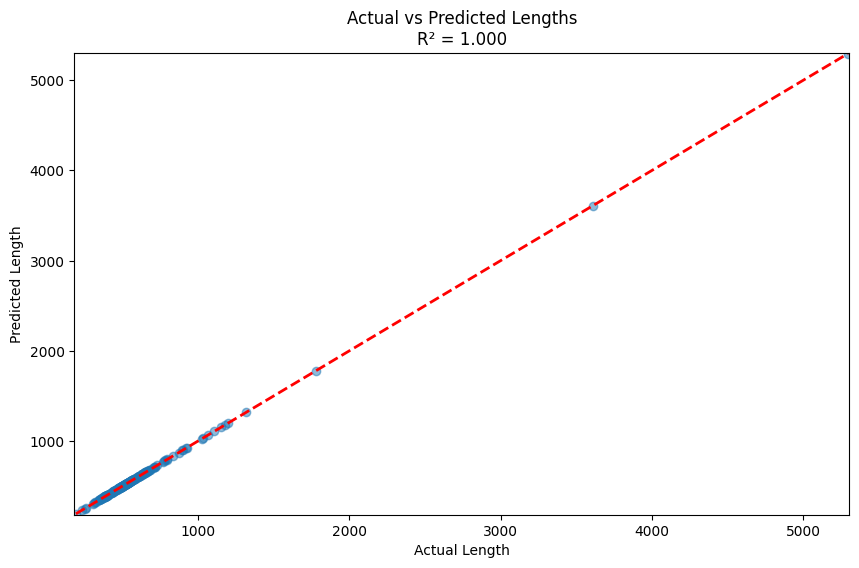

In [71]:
# print(output_lengths.shape) # DEBUG
# print(activations.shape) # DEBUG
# # TODO(Adrianoh): is it bad to have more features than data?
X = activations.numpy()
y = output_lengths.numpy()
assert X.shape[0] == activations.shape[0]
from sklearn.linear_model import LinearRegression

# Fit linear regression model
reg = LinearRegression()
reg.fit(X, y)

# Get R^2 score
r2_score = reg.score(X, y)
print(f"R^2 score: {r2_score:.3f}")

# Print coefficients
print(f"Intercept: {reg.intercept_:.3f}")
print(f"Number of non-zero coefficients: {np.count_nonzero(reg.coef_)}")

# Create predictions for plotting
y_pred = reg.predict(X)

# Create scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)  # Perfect prediction line

plt.xlabel("Actual Length")
plt.ylabel("Predicted Length")
plt.title("Actual vs Predicted Lengths\n" + f"R² = {r2_score:.3f}")

# Add some padding to the axes
plt.xlim(y.min() - 10, y.max() + 10)
plt.ylim(y_pred.min() - 10, y_pred.max() + 10)

plt.show()

Explained variance ratio: 0.221


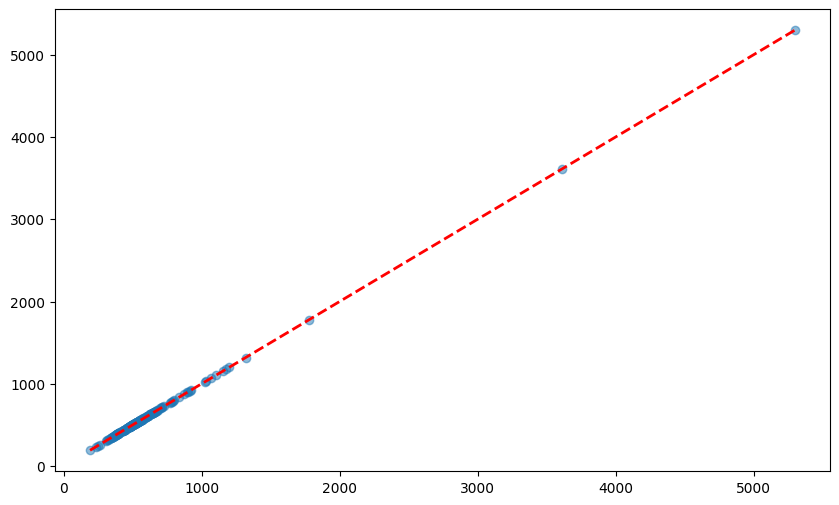

In [72]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
k = 1  # Number of components to keep
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X)
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
assert X_pca.shape == (y.shape[0], k)

# Fit linear regression model on PCA-reduced data
reg = LinearRegression()
reg.fit(X_pca, y)

# Create scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)  # Perfect prediction line

In [ ]:
# Not super mathematically rigorous, but for the dataset above it looks like it's realyl easy to fit. The improtant thing immediately next is to set up
# 1. A set of good datasets
# 2. A sweeper for the datasets